# 💪Laboratorio 3: Registro y análisis de señales EMG de superficie usando BITalino

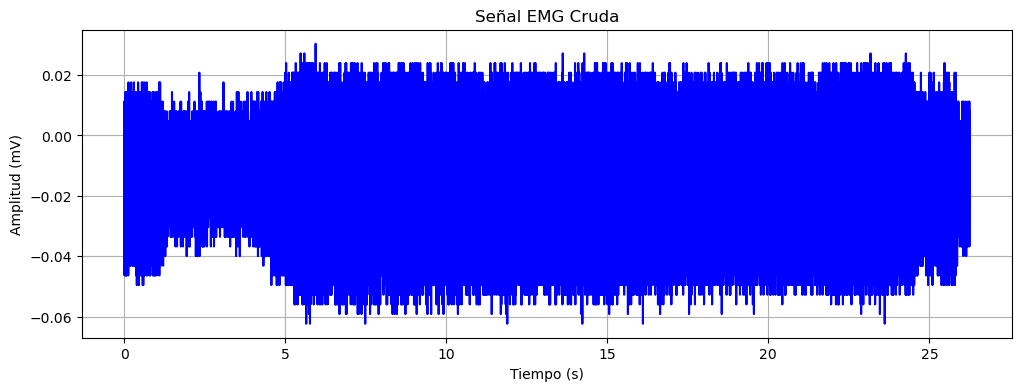

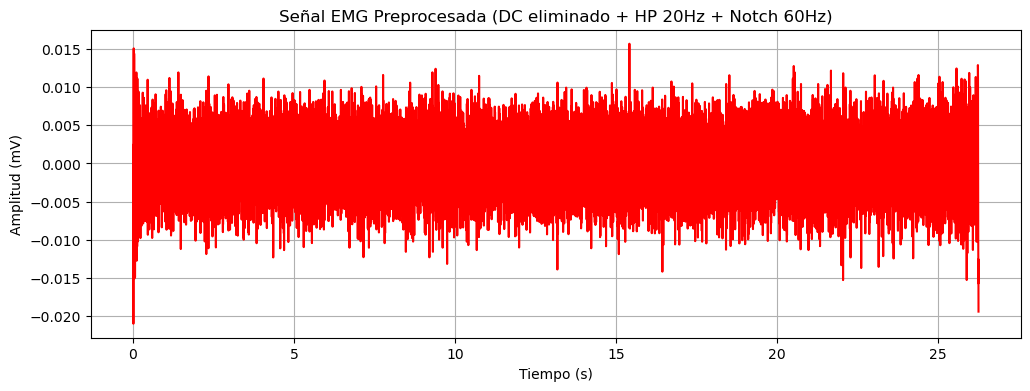

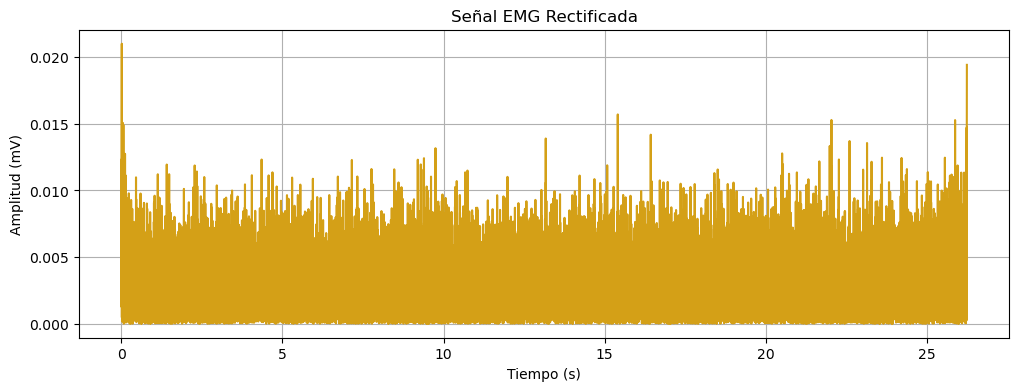

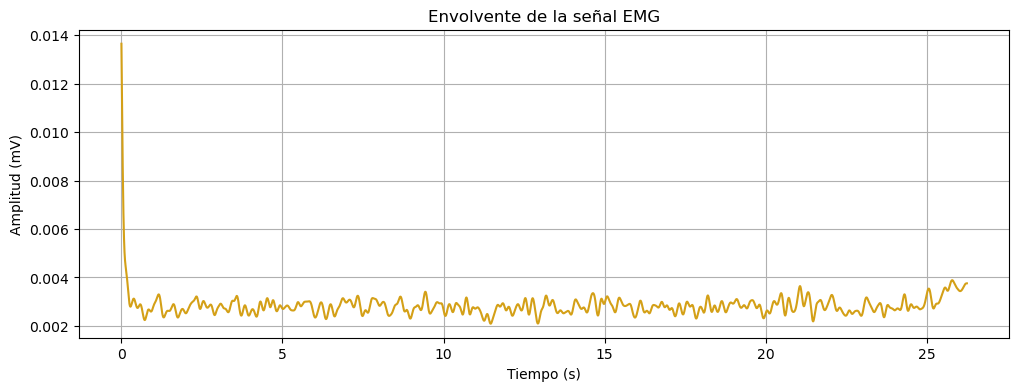

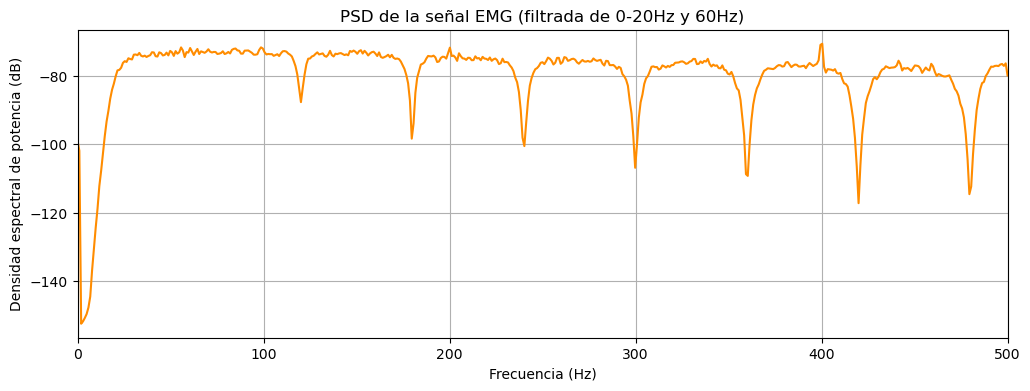

Frecuencias de picos detectados (Hz): [ 33.203125   40.0390625  43.9453125  47.8515625  49.8046875  52.734375
  55.6640625  58.59375    60.546875   64.453125   66.40625    70.3125
  73.2421875  78.125      81.0546875  84.9609375  91.796875   98.6328125
 102.5390625 104.4921875 107.421875  111.328125  128.90625   131.8359375
 135.7421875 138.671875  141.6015625 146.484375  148.4375    152.34375
 154.296875  159.1796875 162.109375  200.1953125 205.078125  400.390625 ]


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, find_peaks

# === 1. Leer archivo de EMG ===
ruta = r"C:\SeñalesLab3\Reposo2Flexor.txt"
df = pd.read_csv(ruta, sep="\t", comment="#",
                 names=["nSeq", "I1", "I2", "O1", "O2", "A1"])

# === 2. Extraer canal O2 ===
ADC = df["O2"].values  # Canal de interés

# === 3. Parámetros del sensor ===
VCC = 3.3
Gain = 1009
ADCres = 1023
fs = 1000  # Frecuencia de muestreo en Hz

# === 4. Conversión ADC → mV ===
EMG_V = ((ADC / ADCres) - 0.5) * VCC / Gain  # Señal en volts
EMG_mV = EMG_V * 1000  # Convertir a mV

# === 5. Quitar componente DC ===
EMG_noDC = EMG_mV - EMG_mV.mean()  # Centrar la señal alrededor de 0

# === 6. Filtro pasa-altas 20 Hz ===
fc = 20  # Frecuencia de corte en Hz
b, a = signal.butter(4, fc/(fs/2), btype='high')  # Butterworth 4º orden
EMG_filtered = signal.filtfilt(b, a, EMG_noDC)  # Filtrado sin desfase

# === 6b. Filtro notch 60 Hz y armónicos hasta 480 Hz ===
EMG_clean = EMG_filtered.copy()
Q = 30  # Factor de calidad para notch (estrecho)
for f_h in np.arange(60, 481, 60):  # 60, 120, 180, ..., 480 Hz
    b_notch, a_notch = signal.iirnotch(f_h, Q, fs)
    EMG_clean = signal.filtfilt(b_notch, a_notch, EMG_clean)  # Aplicar notch

# === 7. Vector de tiempo ===
t = np.arange(len(EMG_clean)) / fs  # Tiempo en segundos

# === 8. Graficar señal cruda ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_mV, color='blue')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Cruda")
plt.grid(True)
plt.show()

# === Graficar señal preprocesada (DC eliminado + HP + Notch) ===
plt.figure(figsize=(12,4))
plt.plot(t, EMG_clean, color='red')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Preprocesada (DC eliminado + HP 20Hz + Notch 60Hz)")
plt.grid(True)
plt.show()

# === 9. Rectificación de la señal ===
EMG_rect = np.abs(EMG_clean)  # Valor absoluto para eliminar negativas
plt.figure(figsize=(12,4))
plt.plot(t, EMG_rect, color='#D4A017')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Señal EMG Rectificada")
plt.grid(True)
plt.show()

# === 10. Calcular envolvente con filtro pasa-bajo 5 Hz ===
fc_env = 5  # Frecuencia de corte para suavizar la señal
b_env, a_env = signal.butter(4, fc_env/(fs/2), btype='low')
EMG_envelope = signal.filtfilt(b_env, a_env, EMG_rect)
plt.figure(figsize=(12,4))
plt.plot(t, EMG_envelope, color='#D4A017')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.title("Envolvente de la señal EMG")
plt.grid(True)
plt.show()

# === 11. PSD (densidad espectral de potencia) en dB usando Welch ===
f_psd, Pxx = welch(EMG_clean, fs=fs, nperseg=1024)  # PSD de la señal filtrada
Pxx_dB = 10 * np.log10(Pxx)  # Convertir a dB

# === Detectar picos en la PSD (opcional) ===
peaks, _ = find_peaks(Pxx_dB, height=np.mean(Pxx_dB)+6)

# === Graficar PSD en dB ===
plt.figure(figsize=(12,4))
plt.plot(f_psd, Pxx_dB, color='darkorange')  # Solo línea de PSD
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("Densidad espectral de potencia (dB)")
plt.title("PSD de la señal EMG (filtrada de 0-20Hz y 60Hz)")
plt.xlim(0, 500)
plt.grid(True)
plt.show()

# === Mostrar frecuencias de picos detectados ===
print("Frecuencias de picos detectados (Hz):", f_psd[peaks])
